In [30]:
import os
import polars as pl
pl.Config(tbl_rows=50)
import matplotlib.pyplot as plt

In [49]:
def read_csv_with_lowercase_columns(file_path: str) -> pl.DataFrame:
    """
    Lee un archivo CSV y convierte todos los nombres de las columnas a minúsculas.

    Parameters:
    file_path (str): La ruta del archivo CSV.

    Returns:
    pl.DataFrame: Un DataFrame de polars con nombres de columnas en minúsculas.
    """
    # Leer el archivo CSV
    df = pl.read_csv(file_path,new_columns=["id"])
    
    # Transformar los nombres de las columnas a minúsculas
    df = df.rename({col: col.lower() for col in df.columns})
    
    return df


def count_unique_values(df: pl.DataFrame, columns: list) -> dict:
    """
    Cuenta los valores únicos de las columnas especificadas en un DataFrame.

    Parameters:
    df (pl.DataFrame): El DataFrame de polars.
    columns (list): Una lista de nombres de columnas para contar los valores únicos.

    Returns:
    dict: Un diccionario con los nombres de las columnas y la cantidad de valores únicos.
    """
    unique_counts = {col: df[col].n_unique() for col in columns}
    return unique_counts

def count_distinct_grouped_by(df: pl.DataFrame, y_column: str, x_columns: list, z_columns: list = None) -> pl.DataFrame:
    """
    Cuenta la cantidad de elementos distintos de una columna Y agrupado por los valores de una o más columnas X,
    ordena los resultados por una o más columnas Z de forma descendente, y calcula el porcentaje sobre el total
    de cada valor de la primera columna de agrupación.

    Parameters:
    df (pl.DataFrame): El DataFrame de polars.
    y_column (str): El nombre de la columna Y cuyos valores distintos se contarán.
    x_columns (list): Una lista de nombres de columnas X por las que se agrupará.
    z_columns (list, optional): Una lista de nombres de columnas Z por las que se ordenará de forma descendente.

    Returns:
    pl.DataFrame: Un nuevo DataFrame con los resultados de la cantidad de valores distintos de Y agrupados por X,
                  ordenados por las columnas Z y con el porcentaje calculado.
    """
    # Agrupar por las columnas X y contar los valores distintos de Y
    result = df.group_by(x_columns).agg([
        pl.col(y_column).n_unique().alias(f"{y_column}_distinct_count")
    ])
    
    # Si hay más de una columna en x_columns, calcular el total por cada valor de la primera columna de agrupación
    if len(x_columns) > 1:
        total_by_first_column = result.group_by(x_columns[0]).agg([
            pl.col(f"{y_column}_distinct_count").sum().alias("total_first_column")
        ])
        
        # Unir los totales al resultado original
        result = result.join(total_by_first_column, on=x_columns[0])
    else:
        # Si solo hay una columna de agrupación, calcular el total general
        total_general = result[f"{y_column}_distinct_count"].sum()
        result = result.with_columns([
            pl.lit(total_general).alias("total_first_column")
        ])
    
    # Calcular el porcentaje
    result = result.with_columns([
        (pl.col(f"{y_column}_distinct_count") / pl.col("total_first_column") * 100).alias(f"{y_column}_percentage")
    ])
    
    # Si se proporcionan columnas Z, ordenar por esas columnas en orden descendente
    if z_columns:
        result = result.sort(by=z_columns, descending = True)
    
    return result

def plot_histograms(df, columns):
    """
    Plots histograms for the specified columns in the DataFrame.

    Parameters:
    df (pl.DataFrame): The DataFrame containing the data.
    columns (list): A list of column names (strings) for which histograms should be plotted.
    """
    num_columns = len(columns)
    fig, axs = plt.subplots(1, num_columns, figsize=(5*num_columns, 5))
    
    if num_columns == 1:
        axs = [axs]  # Ensure axs is iterable if there's only one column

    for i, column in enumerate(columns):
        data = df.select(column).to_series()
        axs[i].hist(data, bins=10, color='skyblue', edgecolor='black')
        axs[i].set_title(f'Histogram of {column}')
        axs[i].set_xlabel(column)
        axs[i].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [3]:
# Read the csv files of the atributes
file_path_atributes = "../data/raw/atributos.csv"
atributes = read_csv_with_lowercase_columns(file_path_atributes)
categorical = ["poc","bussinesssegment","concentracion","nse","segmentounico","canal"]
numerical = ["totalvolumen","skudistintospromediosxorden","skudistintostotales"]
# Read the csv files of the transactions
file_path_transactions = "../data/raw/transacciones.csv"
transactions = read_csv_with_lowercase_columns(file_path_transactions)
# Display the first rows of the DataFrame of the transactions
print(transactions.head())

shape: (5, 6)
┌─────┬────────────┬────────┬──────────────┬───────────────┬──────────────────┐
│ id  ┆ account_id ┆ sku_id ┆ invoice_date ┆ order_id      ┆ items_phys_cases │
│ --- ┆ ---        ┆ ---    ┆ ---          ┆ ---           ┆ ---              │
│ i64 ┆ i64        ┆ i64    ┆ i64          ┆ str           ┆ f64              │
╞═════╪════════════╪════════╪══════════════╪═══════════════╪══════════════════╡
│ 0   ┆ 430606     ┆ 7038   ┆ 20220729     ┆ 512-3880249-0 ┆ 100.0            │
│ 1   ┆ 323267     ┆ 14933  ┆ 20220729     ┆ 512-3882307-0 ┆ 1.0              │
│ 2   ┆ 357825     ┆ 21971  ┆ 20220723     ┆ 512-3852880-0 ┆ 8.0              │
│ 3   ┆ 444926     ┆ 7038   ┆ 20220805     ┆ 512-3913163-0 ┆ 20.0             │
│ 4   ┆ 450771     ┆ 7030   ┆ 20220816     ┆ 512-3957000-0 ┆ 5.0              │
└─────┴────────────┴────────┴──────────────┴───────────────┴──────────────────┘


In [4]:
# Display the first rows of the DataFrame of the atribues
atributes.head()

id,poc,bussinesssegment,totalvolumen,skudistintospromediosxorden,skudistintostotales,concentracion,nse,segmentounico,canal
i64,i64,str,f64,f64,i64,str,str,str,str
10,175519,"""HighUsage""",5.18752,4.1,16,"""Medio""","""Bajo""","""4.Activos""","""Kioscos/Maxikioscos"""
13,28533,"""HighUsage""",4.76866,3.9211,34,"""Alto""","""Medio""","""4.Activos""","""Tradicional"""
19,32182,"""PowerUsage""",5.9793,6.75,34,"""Alto""","""Medio""","""4.Activos""","""Tradicional"""
20,327976,"""MinimalUsage""",6.02852,3.5833,14,"""Alto""","""Medio""","""4.Activos""","""COMIDA"""
24,354640,"""PowerUsage""",7.525,3.2,18,"""Bajo""","""S/D""","""4.Activos""","""Tradicional"""


In [5]:
# measures of central tendency for numerical data
atributes[numerical].describe()

statistic,totalvolumen,skudistintospromediosxorden,skudistintostotales
str,f64,f64,f64
"""count""",4400.0,4400.0,4400.0
"""null_count""",0.0,0.0,0.0
"""mean""",22.272537,5.911031,27.832727
"""std""",106.642437,3.227491,21.640289
"""min""",0.02124,0.7027,1.0
"""25%""",2.12124,3.6667,12.0
"""50%""",5.6011,5.1429,22.0
"""75%""",13.95536,7.3542,38.0
"""max""",4274.44416,33.0,157.0


In [6]:
results = count_unique_values(atributes, numerical)
results

{'totalvolumen': 4323,
 'skudistintospromediosxorden': 1573,
 'skudistintostotales': 124}

In [7]:
results = count_unique_values(atributes, categorical)
results

{'poc': 4400,
 'bussinesssegment': 4,
 'concentracion': 4,
 'nse': 4,
 'segmentounico': 6,
 'canal': 12}

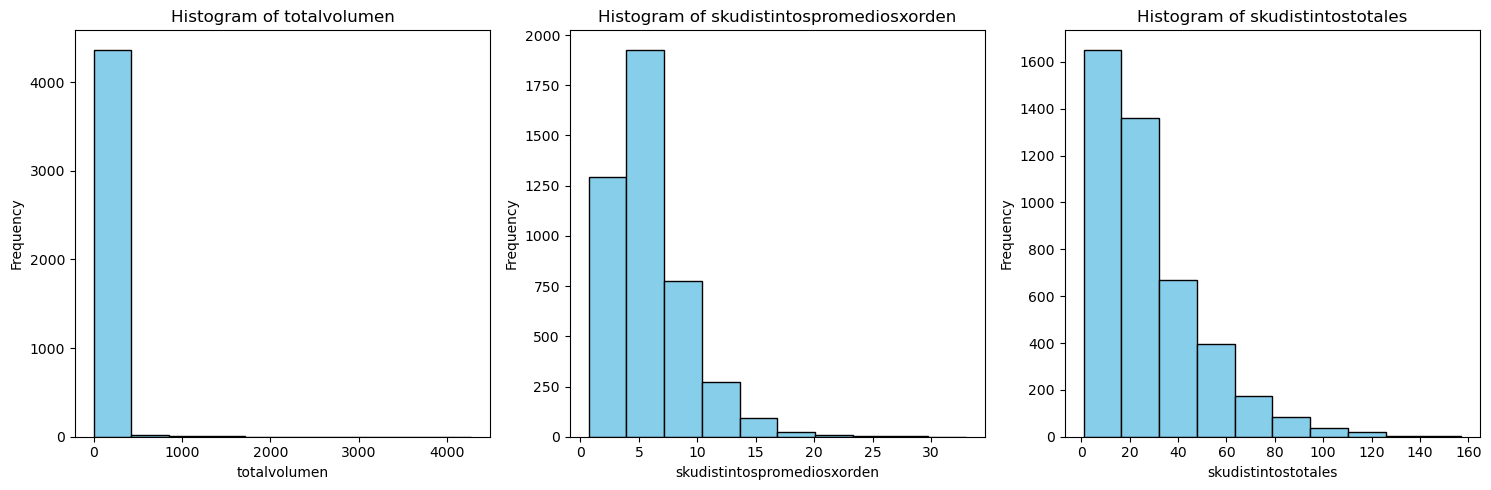

In [8]:
plot_histograms(atributes, numerical)

In [61]:
# Contar la cantidad de valores distintos en 'poc' agrupado por 'bussinesssegment'
result = count_distinct_grouped_by(atributes, y_column="poc", x_columns=["bussinesssegment"],z_columns=["poc_percentage"])
result


bussinesssegment,poc_distinct_count,total_first_column,poc_percentage
str,u32,i32,f64
"""PowerUsage""",1213,4400,27.568182
"""HighUsage""",1213,4400,27.568182
"""MediumUsage""",1050,4400,23.863636
"""MinimalUsage""",924,4400,21.0


In [58]:
# Contar la cantidad de valores distintos en 'poc' agrupado por 'bussinesssegment'
result = count_distinct_grouped_by(atributes, y_column="poc", x_columns=["nse"],z_columns=["poc_percentage"])
result.head(100)

nse,poc_distinct_count,total_first_column,poc_percentage
str,u32,i32,f64
"""Medio""",2430,4400,55.227273
"""S/D""",1023,4400,23.25
"""Bajo""",879,4400,19.977273
"""Alto""",68,4400,1.545455


In [57]:
# Contar la cantidad de valores distintos en 'poc' agrupado por 'bussinesssegment'
result = count_distinct_grouped_by(atributes, y_column="poc", x_columns=["segmentounico"],z_columns=["poc_percentage"])
result

segmentounico,poc_distinct_count,total_first_column,poc_percentage
str,u32,i32,f64
"""4.Activos""",1894,4400,43.045455
"""1.Inactivos""",884,4400,20.090909
"""2.Masivos""",790,4400,17.954545
"""5.Select""",631,4400,14.340909
"""3.Potenciales""",126,4400,2.863636
null,75,4400,1.704545


In [56]:
# Contar la cantidad de valores distintos en 'poc' agrupado por 'bussinesssegment'
result = count_distinct_grouped_by(atributes, y_column="poc", x_columns=["canal"],z_columns=["poc_percentage"])
result

canal,poc_distinct_count,total_first_column,poc_percentage
str,u32,i32,f64
"""Tradicional""",2657,4400,60.386364
"""Kioscos/Maxikioscos""",820,4400,18.636364
"""COMIDA""",412,4400,9.363636
"""Autoservicio""",186,4400,4.227273
"""BEBIDA""",100,4400,2.272727
"""ENTRETENIMIENTO""",79,4400,1.795455
"""Mayorista""",52,4400,1.181818
"""Instituciones""",43,4400,0.977273
"""KA Minoristas""",18,4400,0.409091


In [63]:
# Contar la cantidad de valores distintos en 'poc' agrupado por 'bussinesssegment'
result = count_distinct_grouped_by(atributes, y_column="poc", x_columns=["bussinesssegment","nse"],z_columns=["bussinesssegment","nse"])
result.head(100)


bussinesssegment,nse,poc_distinct_count,total_first_column,poc_percentage
str,str,u32,u32,f64
"""PowerUsage""","""S/D""",229,1213,18.878813
"""PowerUsage""","""Medio""",702,1213,57.873042
"""PowerUsage""","""Bajo""",270,1213,22.258862
"""PowerUsage""","""Alto""",12,1213,0.989283
"""MinimalUsage""","""S/D""",275,924,29.761905
"""MinimalUsage""","""Medio""",487,924,52.705628
"""MinimalUsage""","""Bajo""",147,924,15.909091
"""MinimalUsage""","""Alto""",15,924,1.623377
"""MediumUsage""","""S/D""",264,1050,25.142857
